In [1]:
%matplotlib inline

import pathlib 

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

import numpy as np

typeface='Arial'
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

import importlib.machinery
import importlib.util
import baltic as bt

loader = importlib.machinery.SourceFileLoader('baltic', os.path.join(os.getcwd(), 'baltic_utils.py'))
spec = importlib.util.spec_from_loader(loader.name, loader)
bt_utils = importlib.util.module_from_spec(spec)
loader.exec_module(bt_utils)

base_path=pathlib.Path(os.path.abspath('')).parent
data_path=pathlib.Path(base_path).joinpath("data", "figure_S5")

In [2]:
cfml_path='ClonalFrameML'

stem='alpha_noncoding'
aln_path=str(pathlib.Path(data_path).joinpath('%s.fasta'%(stem)))
tree_path=str(pathlib.Path(data_path).joinpath('%s.newick'%(stem)))
kappa=2.0
out_stem=stem
bt_utils.reconstruct_ancestral_states(cfml_path,str(aln_path),str(tree_path),kappa,out_stem)
ll=bt.loadNewick(tree_path)
ll.treeStats()

bt_utils.annotate_tree(ll,tree_path.replace('.newick','.labelled_tree.newick'),aln_path.replace('.fasta','.reconstructed.fasta'))


Tree height: 0.610903
Tree length: 2.827303
strictly bifurcating tree

Numbers of objects in tree: 43 (21 nodes and 22 leaves)


ClonalFrameML /Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_S5/alpha_noncoding_renamed.newick /Users/carze/Documents/work/ring/projects/anello_diversity/data/figure_S5/alpha_noncoding_renamed.fasta alpha_noncoding -imputation_only true -kappa 2.0


Tree height: 0.610903
Tree length: 2.827303
strictly bifurcating tree

Numbers of objects in tree: 43 (21 nodes and 22 leaves)



In [3]:
all_mutations=set(sum([[mu for mu in k.traits['muts']] for k in ll.Objects if 'muts' in k.traits],[]))
site_mutations={int(mu[1:-1]): [M for M in all_mutations if mu[1:-1]==M[1:-1]] for mu in all_mutations}

mu_branches={}
for site in site_mutations:
    mu_branches[site]={}
    for mut in site_mutations[site]:
        B=ll.getBranches(lambda k: 'muts' in k.traits and mut in k.traits['muts'] and mut[-1]!='-' and mut[0]!='N' and mut[0]!='-' and mut[-1]!='N',warn=False)
        if isinstance(B,list)==False:
            B=[B]
        mu_branches[site][mut]=B

homoplasy_degrees={site: {mut: len(mu_branches[site][mut]) for mut in mu_branches[site]} for site in mu_branches}

In [4]:
# cfml_path='/Users/evogytis/Documents/tools/ClonalFrameML/src/ClonalFrameML'

# stem='alpha_noncoding'
# aln_path='/Users/evogytis/Documents/manuscripts/anello_recombination/data/non-coding/%s.fasta'%(stem)
# tree_path='/Users/evogytis/Documents/manuscripts/anello_recombination/data/non-coding/%s.newick'%(stem)
# kappa=2.3
# out_stem=stem
# ll=bt_utils.reconstruct_ancestral_states(cfml_path,aln_path,tree_path,kappa,out_stem)

# for k in ll.Objects:
#     if 'sequence' in k.parent.traits:
#         par_seq=k.parent.traits['sequence']
#         cur_seq=k.traits['sequence']
#         k.traits['mut']=[]
        
#         for i,pair in enumerate(zip(par_seq,cur_seq)):
#             a,b=pair
#             if a!=b and a not in ['-','N'] and b not in ['-','N']:
#                 k.traits['mut'].append('%s%d%s'%(a,i,b))

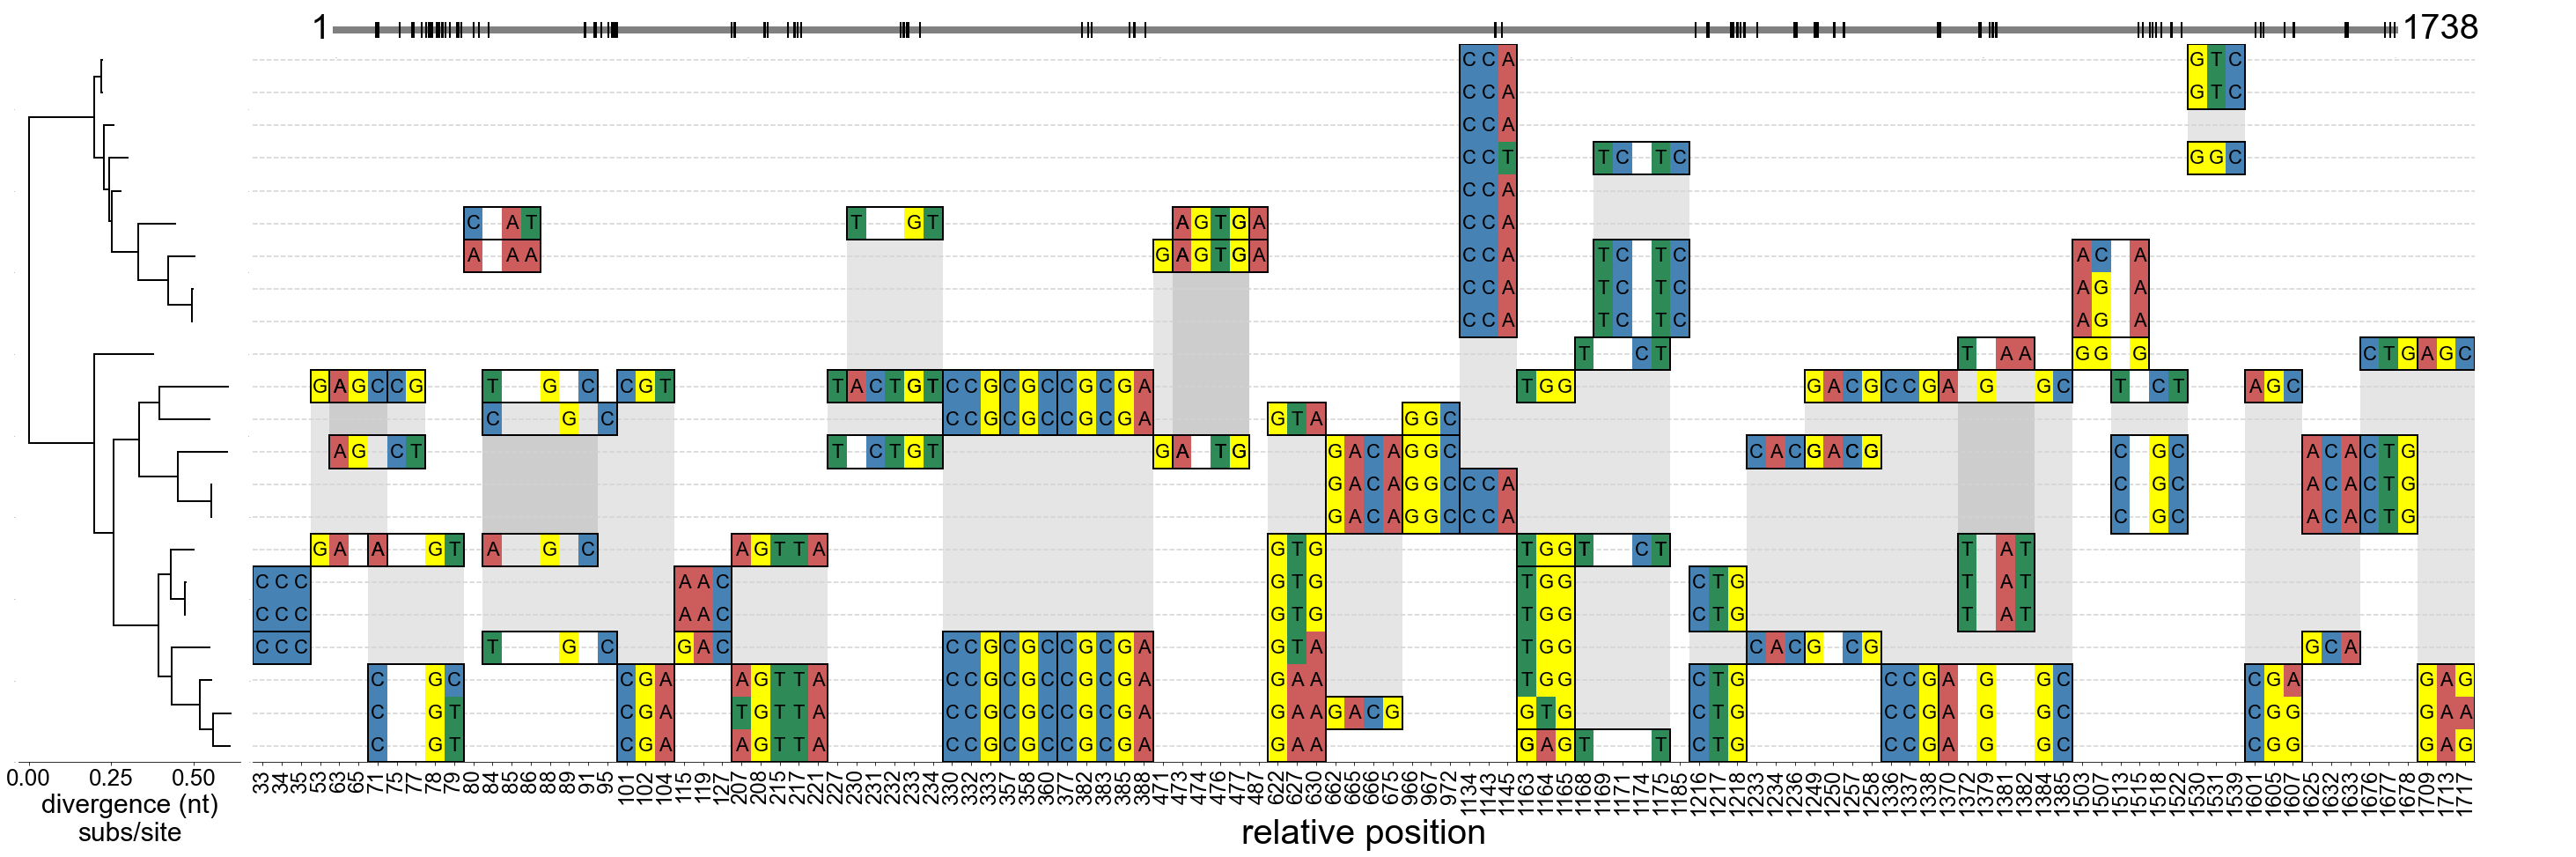

In [9]:
def break_up(sites,threshold):
    segments=[]
    sorted_sites=sorted(sites,key=lambda w: int(w[1:-1]))
    
    local=set()
    
    for i in range(1,len(sorted_sites)):
        cur_site=int(sorted_sites[i][1:-1])
        pre_site=int(sorted_sites[i-1][1:-1])
        
        within_threshold=(cur_site-pre_site)<=threshold
        
        if within_threshold: ## next site within range of previous
            local.add(sorted_sites[i])
            local.add(sorted_sites[i-1])
        else: ## outside threshold but not at last value
            local.add(sorted_sites[i-1])
            segments.append(local)
            local=set()
            
    if len(local)>0:
        segments.append(local)
        
    return segments


fig = plt.figure(figsize=(50, 15),facecolor='w') 
gs = gridspec.GridSpec(1,2,width_ratios=[1,10],wspace=0.01) 

ax=plt.subplot(gs[0],facecolor='w')
ax2=plt.subplot(gs[1],facecolor='w')

ll.traverse_tree()

ll.plotTree(ax)
ax.set_xlabel('divergence (nt)\nsubs/site',size=30)
ax.tick_params(axis='x',labelsize=26)
ax.plot()

from collections import Counter
from matplotlib.patches import Rectangle
mut_freq=Counter(sum([k.traits['muts'] for k in ll.Objects if 'muts' in k.traits],[]))

i=0

xs=[]
ys=[]
ms=[]
import time

y_coords={k.name: k.y for k in ll.getExternal()}
colour={'A': 'indianred', 'C': 'steelblue', 'G': 'yellow', 'T': 'seagreen', '-': 'grey', 'N': 'grey'}

mutated_branches=[k for k in ll.Objects if 'muts' in k.traits]
positions=set()
plot_mus={}

mu_good=lambda mu: '-' not in mu and 'N' not in mu
tract_cutoff=3

for k in mutated_branches: ## iterate over branches
    muts1=set([m for m in k.traits['muts'] if mut_freq[m]>1 and mu_good(m)]) ## only homoplasies
    
    for w in mutated_branches: ## iterate over other branches
        if w!=k: ## not dealing with same branch and branch has mutations
            muts2=set([m for m in w.traits['muts'] if mut_freq[m]>1 and mu_good(m)]) ## get homoplasies on other branch
                
            if len(muts2.intersection(muts1))>=tract_cutoff: ## at least two mutations shared between branches
                for tract in break_up(muts2.intersection(muts1),10): ## break up mutations into chunks within 10 nt of each other
                    if len(tract)>=tract_cutoff: ## tract with at least 4 mutations
                        plot_mus[tuple(tract)]=[k,w]
                        
                        for mutation in tract:
                            site=int(mutation[1:-1])
                            positions.add(site)

unique_xs={x: i for i,x in enumerate(sorted(positions))}

bound_colours=['k']

for t,tract in enumerate(sorted(plot_mus,key=lambda t: min([int(m[1:-1]) for m in t]))): ## iterate over identified tracts
    
    bc=bound_colours[t%len(bound_colours)]
    
    k,w=plot_mus[tract] ## get the two branches involved
    
    A=[k.name] if k.branchType=='leaf' else list(k.leaves) ## get tip name(s) on branch
    B=[w.name] if w.branchType=='leaf' else list(w.leaves)
    
    get_site=lambda mutation: int(mutation[1:-1])
    sites=[unique_xs[x] for x in map(get_site,tract)] ## identify relative positions of mutated sites
    x1,x2=min(sites),max(sites) ## get tract edges
    
    A_span=[y_coords[y] for y in A] ## get y positions of tip(s)
    B_span=[y_coords[y] for y in B]

    A_bounds=Rectangle((x1-0.5,min(A_span)-0.5),(x2-x1)+1,(max(A_span)-min(A_span)+1),facecolor='none',edgecolor=bc,ls='-',lw=2,zorder=100) ## bounding box for tract A
    
    B_bounds=Rectangle((x1-0.5,min(B_span)-0.5),(x2-x1)+1,(max(B_span)-min(B_span)+1),facecolor='none',edgecolor=bc,ls='-',lw=2,zorder=100) ## bounding box for tract B
    
    ax2.add_patch(A_bounds)
    ax2.add_patch(B_bounds)
    
    y1,y2=min([max(A_span)+0.5,max(B_span)+0.5]),max([min(A_span)-0.5,min(B_span)-0.5]) ## upper and lower edges of the two bounding boxes
    
    ax2.add_patch(Rectangle((x1-0.5,y1),x2-x1+1,y2-y1,facecolor=bc,edgecolor='none',zorder=0,alpha=0.1))
    
    for mutation in tract: ## iterate over every mutation in tract
        x=int(mutation[1:-1]) ## get site
        
        for tip in A+B: ## iterate over tips involved
            y=y_coords[tip] ## get tip's y position
            m=ll.getExternal(lambda q: q.name==tip)[0].traits['seq'][x] ## get the state of tip at site in question
            
            ax2.add_patch(Rectangle((unique_xs[x]-0.5,y-0.5),1,1,facecolor=colour[m],edgecolor='none',zorder=2)) ## add nucleotide rectangle in correct colour
            ax2.text(unique_xs[x],y,m,ha='center',va='center',zorder=10000) ## add label too
    
ax2.set_xticks(sorted(list(unique_xs.values())))
ax2.set_xticklabels(sorted(list(unique_xs.keys())),size=24,rotation=90)

ax2.plot()

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines if loc not in ['bottom']]
ax.tick_params(axis='y',size=0,labelsize=0)
ax2.tick_params(axis='y',size=0,labelsize=0)

ax2.set_xlabel('relative position',size=40)

ax2.hlines(np.arange(0.5,ll.ySpan+0.5,1),-0.5,len(unique_xs),ls='--',color='lightgrey')
ax2.set_xlim(-0.5,len(unique_xs)-0.5)
ax.set_ylim(0,ll.ySpan)
ax2.set_ylim(ax.get_ylim())

ax3 = fig.add_axes([0.17, 0.87, 0.76, 0.05], frame_on=False)
ax3.plot([0,1],[0,0],ls='-',color='grey',lw=8)
ax3.text(-0.003,0,'1',size=40,ha='right',va='center')
ax3.text(1+0.003,0,'%d'%(len(ll.root.traits['seq'])),size=40,ha='left',va='center')
ax3.scatter([x/max(unique_xs.keys()) for x in unique_xs.keys()],[0 for y in unique_xs],s=300,marker='|',lw=2,facecolor='k',edgecolor='none',zorder=10)
ax3.set_yticks([])
ax3.tick_params(size=0,labelsize=0)
ax3.set_xlim(-0.085,1.085)

#plt.savefig('/Users/evogytis/Downloads/noncoding_recombination.pdf',dpi=300,bbox_inches='tight')
#plt.savefig('/Users/evogytis/Downloads/noncoding_recombination.png',dpi=300,bbox_inches='tight')

plt.show()


Tree height: 3.891161
Tree length: 311.650050
strictly bifurcating tree

Numbers of objects in tree: 4201 (2100 nodes and 2101 leaves)

R04D01_2019.04.10_nextseq_run_VL46-0475_multiplex_set_B|NODE_5_length_4600_cov_7645.448625|TTV_Clade5|join_near_1899
R07T01_2019.04.10_nextseq_run_VL46-0475_multiplex_set_B|NODE_1_length_3805_cov_1530.489867|TTV_Clade3|join_near_1875
23 22


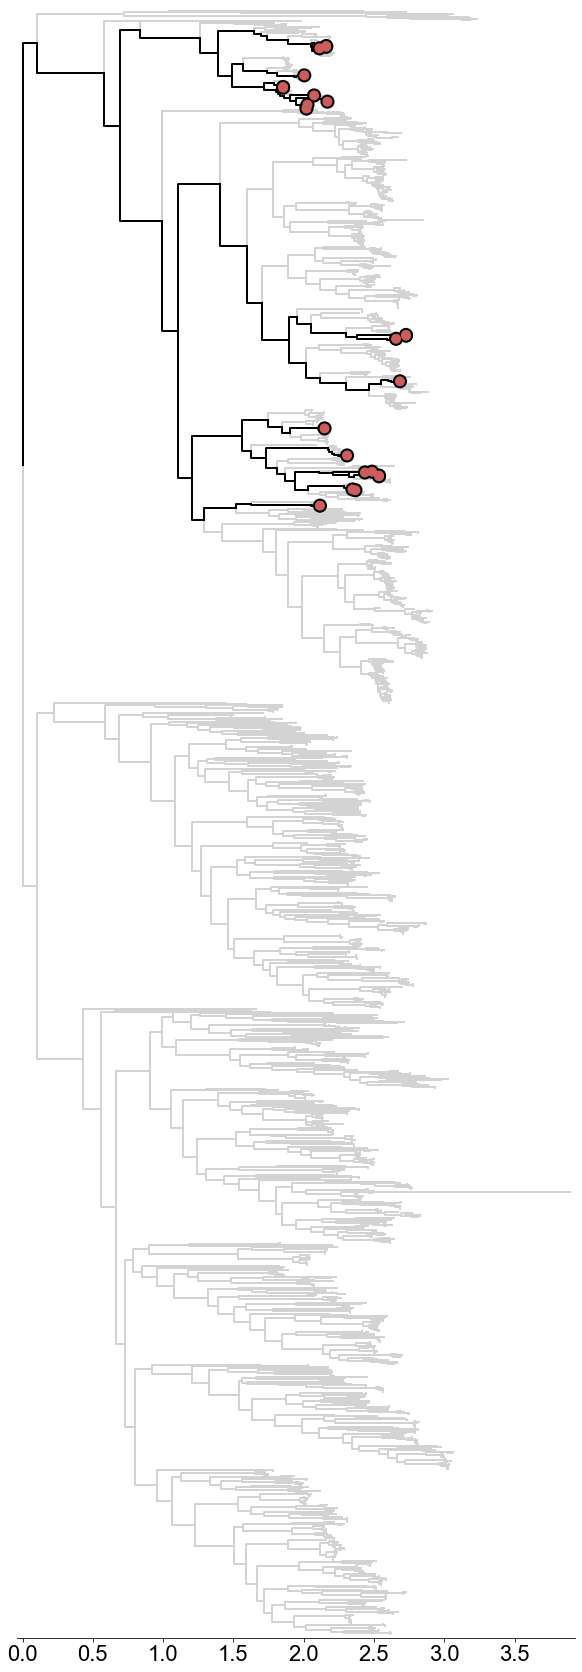

In [34]:
full_tree=bt.loadNewick(pathlib.Path(base_path).joinpath('data', 'figure_1','Anellos.RAxML.newick').as_posix())
full_tree.treeStats()

all_tips=[k.name.split('|')[1] for k in ll.getExternal()]


fig = plt.figure(figsize=(10, 30),facecolor='w') 
#fig = plt.figure(figsize=(30, 10),facecolor='w') 
gs = gridspec.GridSpec(1,1,wspace=0.01) 

ax=plt.subplot(gs[0],facecolor='w')

target=lambda k: k.branchType=='leaf' and (k.name.split('|')[1] in all_tips or k.name.split('|')[1]=='NODE_1_length_3730_cov_142.561361')

for k in ll.getExternal():
    if k.name.split('|')[1] not in [w.name.split('|')[1] for w in full_tree.getExternal()]:
        print(k.name)
    
# R04D01_2019.04.10_nextseq_run_VL46-0475_multiplex_set_B|NODE_5_length_4600_cov_7645.448625|TTV_Clade5|join_near_1899 ## dropped because too long
# R07T01-TTVRCA_S7_2019.02.06_iseq_run_VL46-0348_R07D05-R07T01-4|NODE_1_length_3730_cov_142.561361|TTV_Clade3_889_4_1 ## collapsed to 'NODE_1_length_3730_cov_142.561361'
        
full_tree.plotPoints(ax,target=target,colour='indianred',size=100,zorder=1000)

print(len(full_tree.getBranches(target)),len(all_tips))

root_path=set()
for k in full_tree.getBranches(target):
    cur_node=k
    while cur_node:
        root_path.add(cur_node)
        cur_node=cur_node.parent

target=lambda k: k in root_path
        
full_tree.plotTree(ax,connection_type='elbow',target=target,colour='k',zorder=100)
full_tree.plotTree(ax,connection_type='elbow',target=lambda w: target(w)==False,colour='lightgrey',zorder=1)

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylim(-5,full_tree.ySpan+5)
ax.set_xlim(-0.01*full_tree.treeHeight,full_tree.treeHeight*1.01)

#plt.show()
plt.plot(-x, -y)

In [7]:
from Bio import SeqIO

cfml_path='/Users/evogytis/Documents/tools/ClonalFrameML/src/ClonalFrameML'

stem='5UTR'
aln_path='/Users/evogytis/Documents/manuscripts/anello_recombination/data/non-coding/%s.fasta'%(stem)
tree_path='/Users/evogytis/Documents/manuscripts/anello_recombination/data/non-coding/%s.newick'%(stem)
kappa=2.3
out_stem=stem
bt_utils.reconstruct_ancestral_states(cfml_path,aln_path,tree_path,kappa,out_stem)

ll=bt.loadNewick(tree_path)
ll.treeStats()

bt_utils.annotate_tree(ll,tree_path.replace('.newick','.labelled_tree.newick'),aln_path.replace('.fasta','.reconstructed.fasta'))


full_tree=bt.loadNewick('/Users/evogytis/Documents/manuscripts/anello_recombination/data/Anellos_aa.RAxML.newick')
full_tree=full_tree.collapseBranches(lambda k: k.length<1/100)
full_tree.treeStats()


Tree height: 1.240460
Tree length: 10.590580
strictly bifurcating tree

Numbers of objects in tree: 1543 (771 nodes and 772 leaves)


/Users/evogytis/Documents/tools/ClonalFrameML/src/ClonalFrameML /Users/evogytis/Documents/manuscripts/anello_recombination/data/non-coding/5UTR_renamed.newick /Users/evogytis/Documents/manuscripts/anello_recombination/data/non-coding/5UTR_renamed.fasta 5UTR -imputation_only true -kappa 2.3


Tree height: 1.240460
Tree length: 10.590580
strictly bifurcating tree

Numbers of objects in tree: 1543 (771 nodes and 772 leaves)


Tree height: 3.891161
Tree length: 313.876203

Numbers of objects in tree: 3763 (1662 nodes and 2101 leaves)



66 73


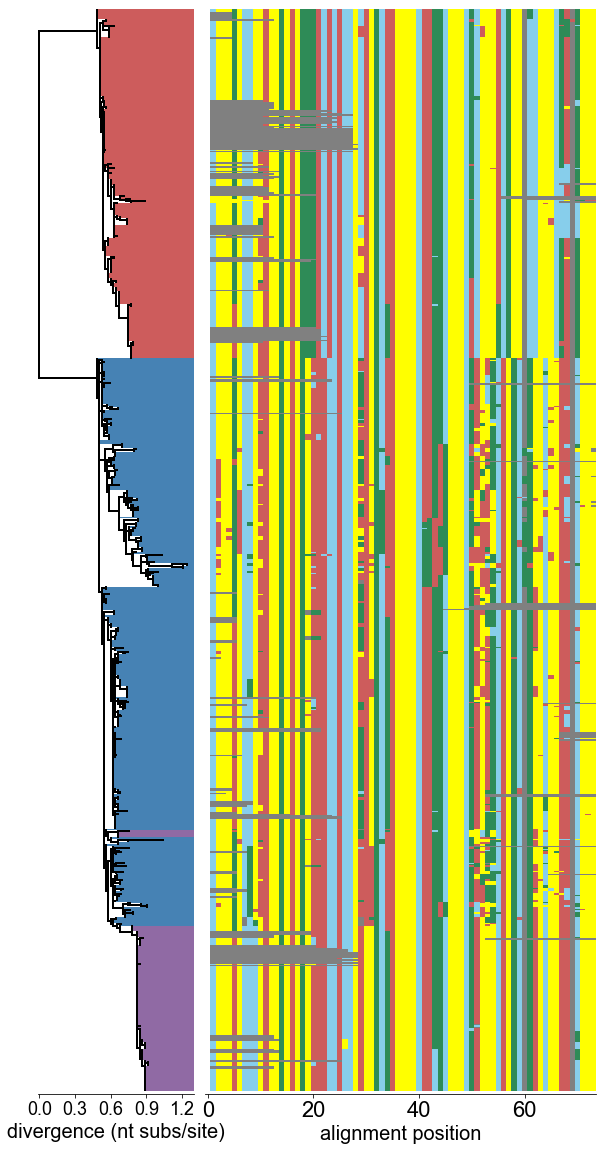

In [8]:
fig = plt.figure(figsize=(10, 20),facecolor='w') 
gs = gridspec.GridSpec(1,2,width_ratios=[4,10],wspace=0.04) 

ax=plt.subplot(gs[0],facecolor='w')
ax2=plt.subplot(gs[1],facecolor='w')

seqs={}
for seq in SeqIO.parse(aln_path,'fasta'):
    seqs[seq.id]=seq.seq
    
alnL=len(seqs[seq.id])
polymorphic=[i for i in range(alnL) if len(set([s[i] for s in seqs.values()]))>1]
print(len(polymorphic),alnL)

genus=lambda k: k.name.split('|')[-1].split('_')[0]
genus_colours={'Alpha': 'indianred','Beta': 'steelblue', 'Gamma': '#906AA4'}

colour={'A': 'indianred', 'C': 'skyblue', 'G': 'yellow', 'T': 'seagreen', '-': 'grey', 'N': 'grey'}

for k in ll.getExternal():
    
    ax.add_patch(Rectangle((k.x,k.y-0.5),1+ll.treeHeight-k.x,1,facecolor=genus_colours[genus(k)],edgecolor='none',zorder=0))
    
    for i in range(alnL):
        ax2.add_patch(Rectangle((i-0.5+1,k.y-0.5),1,1,facecolor=colour[seqs[k.name][i]],edgecolor='none',zorder=1))

# ax2.axvline(-0.5,color='k')
ll.plotTree(ax,zorder=5)

colour=lambda k: genus_colours[genus(k)]

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.3))

ax.tick_params(labelsize=18)
ax.set_xlabel('divergence (nt subs/site)',size=20)
ax2.set_xlabel('alignment position',size=20)

ax2.set_xlim(-0.5,alnL+0.5)
ax.set_xlim(-0.01*ll.treeHeight,1.05*ll.treeHeight)

ax.set_ylim(-2,ll.ySpan+2)
ax2.set_ylim(ax.get_ylim())
# ax2.plot()

ax.set_yticks([])
ax.set_yticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines if loc not in ['bottom']]

plt.savefig('/Users/evogytis/Downloads/5UTR_treealignment.pdf',dpi=300,bbox_inches='tight')
plt.savefig('/Users/evogytis/Downloads/5UTR_treealignment.png',dpi=300,bbox_inches='tight')

plt.show()